In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

!unzip -u "/content/drive/MyDrive/research-project/dilbert-stuff/resized.zip" -d "/content/resized"

!mkdir resized2
!mkdir model
!mv /content/resized/resized /content/resized2

Mounted at /content/drive
Archive:  /content/drive/MyDrive/research-project/dilbert-stuff/resized.zip
   creating: /content/resized/resized/
  inflating: /content/resized/resized/2008-10-12_0.png  
  inflating: /content/resized/resized/2008-07-14_0.png  
  inflating: /content/resized/resized/2010-08-08_6.png  
  inflating: /content/resized/resized/2008-11-12_0.png  
  inflating: /content/resized/resized/2008-06-14_0.png  
  inflating: /content/resized/resized/2007-09-02_6.png  
  inflating: /content/resized/resized/2010-05-16_7.png  
  inflating: /content/resized/resized/2008-01-11_1.png  
  inflating: /content/resized/resized/2010-11-19_1.png  
  inflating: /content/resized/resized/2009-03-08_1.png  
  inflating: /content/resized/resized/2008-08-03_7.png  
  inflating: /content/resized/resized/2009-09-13_1.png  
  inflating: /content/resized/resized/2007-10-13_1.png  
  inflating: /content/resized/resized/2007-07-15_1.png  
  inflating: /content/resized/resized/2010-10-19_1.png  
  in

In [ ]:
datapath = '/content/resized2/'

import torch
import torch.nn as nn

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [ ]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"



In [ ]:
!pip install tensorboard

Show some training samples
Epoch [0/30] Batch 20/73                   Loss D: -22.9576, loss G: 12.4550
Epoch [0/30] Batch 40/73                   Loss D: -53.4196, loss G: 27.0574
Epoch [0/30] Batch 60/73                   Loss D: -75.6574, loss G: 38.4054
Epoch [1/30] Batch 20/73                   Loss D: -99.3529, loss G: 54.7813
Epoch [1/30] Batch 40/73                   Loss D: -107.1200, loss G: 63.6475
Epoch [1/30] Batch 60/73                   Loss D: -119.0659, loss G: 71.5525
Epoch [2/30] Batch 20/73                   Loss D: -127.8818, loss G: 83.6998
Epoch [2/30] Batch 40/73                   Loss D: -125.4715, loss G: 87.6492
Epoch [2/30] Batch 60/73                   Loss D: -129.1805, loss G: 95.0986
Epoch [3/30] Batch 20/73                   Loss D: -115.8062, loss G: 100.3437
Epoch [3/30] Batch 40/73                   Loss D: -108.9934, loss G: 104.2211
Epoch [3/30] Batch 60/73                   Loss D: -103.4381, loss G: 106.2708
Epoch [4/30] Batch 20/73              

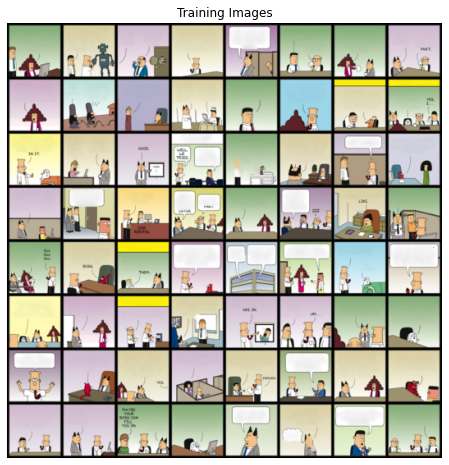

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 30
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
loss_gen_track = []
loss_disc_track = []

img_lst = []

import torchvision.transforms as transforms


transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

# dataset = datasets.MNIST(root="../dataset/cropped/", transform=transforms, download=True)

dataset = datasets.ImageFolder(root=datapath, transform=transforms)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

print("Show some training samples")
real_batch = next(iter(loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0]
                                         .to(torch.device(device))[:64], padding=2, normalize=True).cpu(),(1,2,0)))


gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)


opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))


fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

gen.train()
critic.train()

# !tensorboard --logdir=logs

for epoch in range(NUM_EPOCHS):

    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()


        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()


        if batch_idx % 20 == 0 and batch_idx > 0:
            gen_loss_file = open("model/gen_loss.txt", 'a')
            disc_loss_file = open("model/disc_loss.txt", 'a')
            # print(type(loss_gen))
            # print(loss_gen)
            gen_loss_file.write(" %f , " % loss_gen.item())
            disc_loss_file.write(" %f , " % loss_critic.item())
            gen_loss_file.close()
            disc_loss_file.close()
            # loss_gen_track.append(loss_gen)
            # loss_disc_track.append(loss_critic)
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

writer_real.flush()
writer_fake.flush()
writer_real.close()
writer_fake.close()

gen = torch.save(gen, "/content/model/full_model.pt")
# np.savetxt("model/gen_loss.txt", loss_gen_track, delimiter=',')
# np.savetxt("model/disc_loss.txt", loss_disc_track, delimiter=',')


In [ ]:
!pip install tensorboard



2021-05-16 09:02:47.033110: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--whatif-use-unsafe-custom-prediction YOUR_CUSTOM_PREDICT_FUNCTION.py]
                   [--whatif-data-dir PATH]
                   {serve,dev} ...
tensorboard: error: invali

In [ ]:
!tensorboard --logdir=/content/logs/GAN_MNIST/

2021-05-16 09:04:07.977019: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


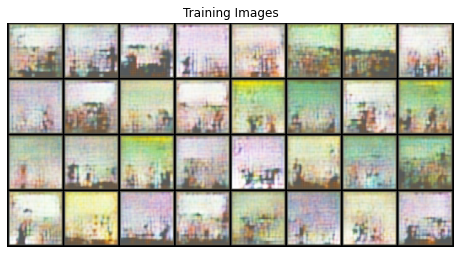

In [ ]:
model = torch.load("model/full_model.pt")

fake = model(fixed_noise).detach().cpu()

fake_disp = vutils.make_grid(fake, padding=2, normalize=True)

# real_batch = next(iter(loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(fake_disp,(1,2,0)))

!mkdir fake_images

for i, fake_tensor in enumerate(fake):
  fake-name = "fake_images/fake_" + str(i)
  vutils.save_image(fake_tensor, fp=fake_name)


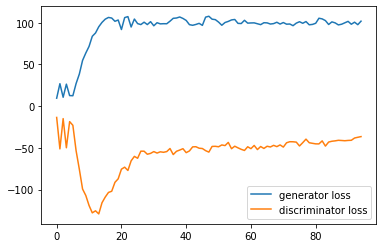

In [ ]:
from numpy import genfromtxt
import matplotlib.pyplot as plt

data_gen = genfromtxt("model/gen_loss.txt", delimiter=",")
data_disc = genfromtxt("model/disc_loss.txt", delimiter=",")
plt.plot(data_gen)
plt.plot(data_disc)
plt.legend(["generator loss", "discriminator loss"], loc='lower right')
plt.show()

In [ ]:
!mv /content/model/full_model.pt /content/drive/MyDrive/research-project/dilbert-stuff/models/